 ### Dataset Extraction

In [86]:
# import tarfile

# archive_path = '/kaggle/input/150k-python-dataset/py150.tar_1'
# output_dir = '/kaggle/working/py150'

# with tarfile.open(archive_path) as tar:
#     tar.extractall(output_dir)

# print("Extracted files to:", output_dir)

### Imports

In [87]:
import json
import numpy as np
from collections import defaultdict
import pickle
import os
import re

import matplotlib.pyplot as plt
from scipy.stats import randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Configuration


In [88]:
# Directory where Kaggle datasets are typically located after unzipping
DATA_DIR = "/kaggle/working/py150/"

# Filenames for the dataset
# Note: The actual dataset from Kaggle has '.jsonl' extension
TRAIN_FILENAME = "python100k_train.json"
EVAL_FILENAME = "python50k_eval.json"

# Filepath for the saved model in the output directory
MODEL_FILENAME = "code_eval_w_150k.pkl"
MODEL_PATH = f"/kaggle/working/{MODEL_FILENAME}"

# Training parameters
MAX_SAMPLES = 10000 # Use a smaller number for faster runs
RANDOM_STATE = 42

### Feature Extraction

In [89]:
class MLCodeCriticAST:
    # Initializer Constructor
    def __init__(self):
        # 3 Random Forsest with 50 decision trees
        self.quality_classifier = RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE)
        self.naming_classifier = RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE)
        self.style_classifier = RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE)
        # Normalizing Features
        self.scaler = StandardScaler()
        #Check whether model is trainind or not
        self.is_trained = False

    def extract_features_from_ast(self, ast_json):
        # Store count of various node types (class, func, etc) 
        node_counts = defaultdict(int)
        # identifier name list
        names = []
        for node in ast_json:
            if isinstance(node, dict) and 'type' in node:
                node_type = node['type']
                node_counts[node_type] += 1 # node type counter incrementor
                if 'value' in node and isinstance(node['value'], str): # check for indentifier names
                    names.append(node['value'])
        
        # Naming and style features
        name_len = np.mean([len(n) for n in names]) if names else 0 # mean lenght of identifiers

        # Snake and Camel case check
        snake_case = sum(
                    1 for n in names
                    if re.fullmatch(r'[a-z]+(_[a-z]+)+', n)
        )
        
        camel_case = sum(
                    1 for n in names
                    if re.fullmatch(r'[a-z]+([A-Z][a-z0-9]*)+', n)
        )

        
        # Complexity
        complexity = node_counts['If'] + node_counts['For'] + node_counts['While']

        # Array of extracted features
        features = np.array([
            node_counts['FunctionDef'], node_counts['ClassDef'], node_counts['Assign'],
            node_counts['Import'] + node_counts['ImportFrom'], complexity,
            node_counts['NameStore'], node_counts['NameLoad'], len(names), len(ast_json),
            node_counts['Call'], node_counts['attr'], node_counts['Str'], node_counts['Return'],
            node_counts['arguments'], node_counts['body'],
            name_len, snake_case, camel_case, 0, 0 # Padding for consistent feature count
        ], dtype=float)
        return features

   

### Dataset to Heuristics for training

In [90]:
def load_py150_jsonl(self, filepath, max_samples):
    data = []
    print(f"Loading {max_samples} samples...")
    if not os.path.exists(filepath):
        print(f"Error: File not found at {filepath}")
        return []

    with open(filepath, 'r') as f:
        for i, line in enumerate(f):
            if i >= max_samples:
                break
            try:
                ast_json = json.loads(line)
                features = self.extract_features_from_ast(ast_json)
                
                # Heuristic-based labeling for training
                quality = min(100, max(0, 30  # Lower base score
                            + 15 * (features[0] > 1)    # More points for functions
                            + 15 * (features[1] > 0)    # More points for classes  
                            + 10 * (features[3] > 2)    # Bonus for good imports
                            + 10 * (features[12] >= 1)  # Return statements
                            + 15 * (features[0] > 3)    # Extra bonus for many functions
                            - 15 * (features[4] > 10)   # Bigger complexity penalty
                            - 20 * (features[4] > 20)   # Severe complexity penalty
                            - 10 * (features[7] < 3)    # Penalty for too few names
                        ))
                        
                naming = min(100, max(0, 20   # Lower base score
                            + 20 * (features[15] > 8)   # Longer names bonus
                            + 15 * (features[16] >= 3)  # Good snake_case usage
                            + 10 * (features[16] >= 5)  # Excellent snake_case
                            - 20 * (features[16] == 0 and features[17] == 0)  # No convention
                            - 15 * (features[17] > features[16])  # Prefer snake_case
                            - 10 * (features[15] < 4)   # Too short names
                        ))
                        
                style = min(100, max(0, 25    # Lower base score
                            + 15 * (features[3] > 0)    # Has imports
                            + 10 * (features[3] > 2)    # Good import usage
                            + 15 * (features[12] >= 1)  # Has returns
                            + 10 * (features[9] > 5)    # Good function calls
                            - 15 * (features[11] > 8)   # Too many strings
                            - 10 * (features[11] > 15)  # Way too many strings
                            - 15 * (features[8] < 10)   # Too few total nodes
                        ))
                
                data.append({
                    "features": features,
                    "quality_score": quality,
                    "naming_score": naming,
                    "style_score": style
                })
            except json.JSONDecodeError:
                continue
    
    print(f"Successfully loaded {len(data)} samples.")
    return data

# Add this method to the class
MLCodeCriticAST.load_py150_jsonl = load_py150_jsonl


 ### Splilting, normalizing and scaling data

In [91]:
def train_models(self, train_data):
    print("\nTraining Model")
    X = np.array([d["features"] for d in train_data])

    #Creates labels for all 3 score types (excellent, good, fair, poor)
    y_quality = np.array([self._score_to_category(d["quality_score"]) for d in train_data])
    y_naming = np.array([self._score_to_category(d["naming_score"]) for d in train_data])
    y_style = np.array([self._score_to_category(d["style_score"]) for d in train_data])
    
    # Split data for all models
    X_train, X_test, yq_train, yq_test, yn_train, yn_test, ys_train, ys_test = train_test_split(
        X, y_quality, y_naming, y_style, test_size=0.2, random_state=RANDOM_STATE, stratify=y_quality
    )

    # Normalizing data
    self.scaler.fit(X_train)
    X_train_scaled = self.scaler.transform(X_train)
    X_test_scaled = self.scaler.transform(X_test)

    # Tune, train, and evaluate each model
    self.quality_classifier = self._tune_and_train(X_train_scaled, yq_train, 'Quality')
    self._evaluate_and_plot(X_test_scaled, yq_test, self.quality_classifier, 'Quality')

    self.naming_classifier = self._tune_and_train(X_train_scaled, yn_train, 'Naming')
    self._evaluate_and_plot(X_test_scaled, yn_test, self.naming_classifier, 'Naming')

    self.style_classifier = self._tune_and_train(X_train_scaled, ys_train, 'Style')
    self._evaluate_and_plot(X_test_scaled, ys_test, self.style_classifier, 'Style')

    self.is_trained = True
    print("\n=== Training Complete ===")

# Add this method to the class
MLCodeCriticAST.train_models = train_models


In [92]:
# Tune and train model
def _tune_and_train(self, X_train, y_train, model_name):
    print(f"\n--- Tuning {model_name} Model ---")

    # Define random Hyper Parameters for Random Forest
    param_dist = {
        'n_estimators': randint(50, 200), 'max_depth': randint(5, 20),
        'min_samples_split': randint(2, 11), 'min_samples_leaf': randint(1, 5)
    }

    # Using 15 x 3 = 45 () Decision trees for random forest
    rand_search = RandomizedSearchCV(
        RandomForestClassifier(random_state=RANDOM_STATE), param_distributions=param_dist, 
        n_iter=15, cv=3, scoring='f1_macro', random_state=RANDOM_STATE, n_jobs=-1
    )

    # Tuning process
    rand_search.fit(X_train, y_train)
    
    print(f"Best Score: {rand_search.best_score_:.3f}")
    return rand_search.best_estimator_

# Evaluating on train data and displaying Confusion Matrix
def _evaluate_and_plot(self, X_test, y_test, model, model_name):
    print(f"\n==Evaluating {model_name} Model==")
    # Predict based on test data
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=plt.cm.Blues)
    plt.title(f'{model_name} Model Confusion Matrix')
    plt.show()

# Assign score to categories
def _score_to_category(self, score):
    if score >= 65: return 'excellent'
    if score >= 55: return 'good'
    if score >= 45: return 'fair'
    return 'poor'

# Adding methods to class
MLCodeCriticAST._tune_and_train = _tune_and_train
MLCodeCriticAST._evaluate_and_plot = _evaluate_and_plot
MLCodeCriticAST._score_to_category = _score_to_category


In [93]:
def predict(self, ast_json):
    if not self.is_trained: 
        return {"error": "Model not trained."}
    # Extract features from dataset and convert to Matrix (1D -> 2D), and normalizing
    features = self.extract_features_from_ast(ast_json).reshape(1, -1)
    X_scaled = self.scaler.transform(features)

    quality_pred = self.quality_classifier.predict(X_scaled)[0]
    naming_pred = self.naming_classifier.predict(X_scaled)[0]
    style_pred = self.style_classifier.predict(X_scaled)[0]
    
    return {
        'quality': quality_pred,
        'naming': naming_pred,
        'style': style_pred,
        'suggestions': self._generate_suggestions(quality_pred, naming_pred, style_pred)
    }

# Basic suggestions for given score/grade
def _generate_suggestions(self, quality, naming, style):
    suggestions = []
    if quality in ['fair', 'poor']: 
        suggestions.append("🔧 Improve structure: Reduce complex functions and nesting.")
    if naming in ['fair', 'poor']: 
        suggestions.append("📝 Improve naming: Use descriptive, consistent variable names.")
    if style in ['fair', 'poor']: 
        suggestions.append("✨ Improve style: Check formatting, spacing, and comments.")
    if not suggestions: 
        return ["✅ Great work! Code looks clean and follows good practices."]
    return suggestions

# Saving model
def save(self, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(self, f)
    print(f"Model saved to {filepath}")

@staticmethod
def load(filepath):
    with open(filepath, 'rb') as f:
        return pickle.load(f)

# Add these methods to the class
MLCodeCriticAST.predict = predict
MLCodeCriticAST._generate_suggestions = _generate_suggestions
MLCodeCriticAST.save = save
MLCodeCriticAST.load = load


### Load Training Data

In [94]:
critic = MLCodeCriticAST()
train_filepath = os.path.join(DATA_DIR, TRAIN_FILENAME)
train_data = critic.load_py150_jsonl(train_filepath, max_samples=MAX_SAMPLES)

Loading 10000 samples...
Successfully loaded 10000 samples.


### Train the Models
.


Training Model

--- Tuning Quality Model ---
Best Score: 0.974

==Evaluating Quality Model==
              precision    recall  f1-score   support

   excellent       0.99      1.00      0.99       937
        fair       0.95      0.96      0.95       174
        good       0.99      0.98      0.98       331
        poor       1.00      0.98      0.99       558

    accuracy                           0.99      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.99      0.99      0.99      2000



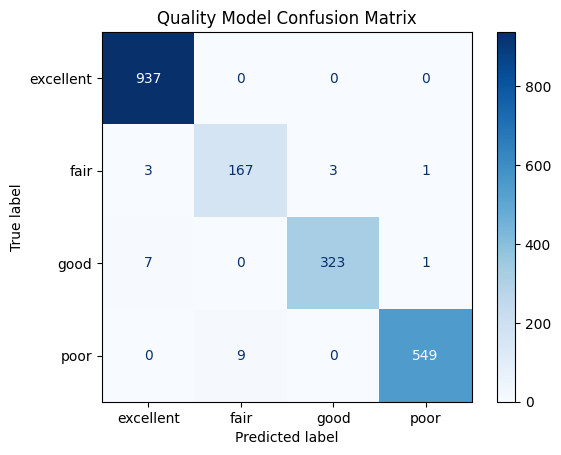


--- Tuning Naming Model ---
Best Score: 0.980

==Evaluating Naming Model==
              precision    recall  f1-score   support

   excellent       0.99      1.00      0.99       909
        fair       0.98      0.97      0.97       403
        good       1.00      0.98      0.99       124
        poor       0.99      0.99      0.99       564

    accuracy                           0.99      2000
   macro avg       0.99      0.98      0.99      2000
weighted avg       0.99      0.99      0.99      2000



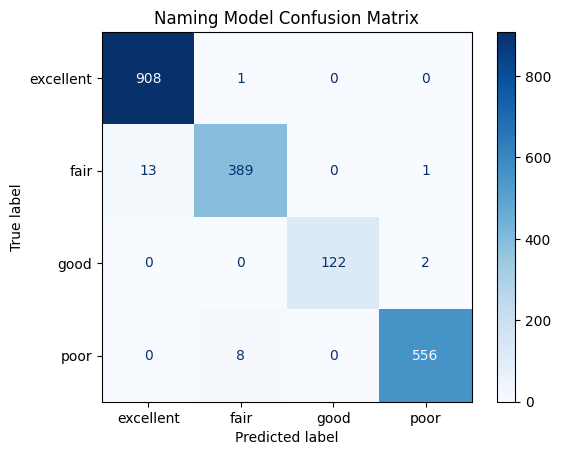


--- Tuning Style Model ---
Best Score: 0.994

==Evaluating Style Model==
              precision    recall  f1-score   support

   excellent       0.99      1.00      1.00       204
        fair       1.00      0.99      1.00       750
        good       1.00      1.00      1.00       360
        poor       0.99      1.00      1.00       686

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



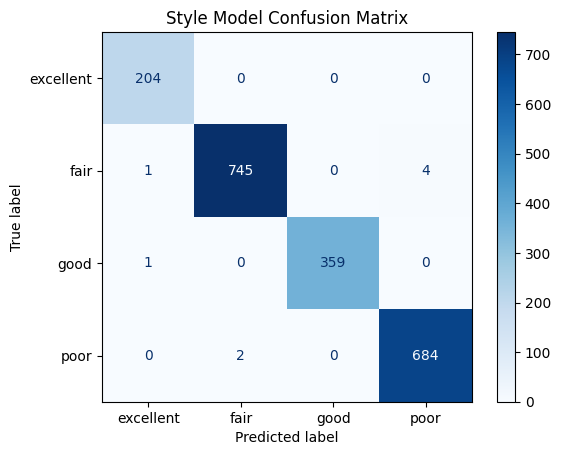


=== Training Complete ===


In [95]:
if train_data:
    critic.train_models(train_data)
else:
    print("Skipping training because no data was loaded. Check file paths and names.")

### Save the Final Model


In [96]:
if critic.is_trained:
    critic.save(MODEL_PATH)
else:
    print("Model not trained. Skipping save.")

Model saved to /kaggle/working/code_eval_w_150k.pkl


### Inference on Evaluation Data


In [97]:
if os.path.exists(MODEL_PATH):
    print(f"Loading model from {MODEL_PATH}...")
    inference_critic = MLCodeCriticAST.load(MODEL_PATH)
    eval_size = 50
    eval_filepath = os.path.join(DATA_DIR, EVAL_FILENAME)
    if os.path.exists(eval_filepath):
        print(f"\n==Critiquing {eval_size} samples from the evaluation set:==")
        with open(eval_filepath, "r") as f:
            for i, line in enumerate(f):
                if i >= eval_size: break
                try:
                    # Read each code sample
                    ast_json = json.loads(line) 

                    # Store it in result
                    result = inference_critic.predict(ast_json)

                    # Print category and suggestion
                    print(f"\n--- Sample {i+1} ---")
                    print(f"  Quality: {result['quality']}")
                    print(f"  Naming:  {result['naming']}")
                    print(f"  Style:   {result['style']}")
                    print("  Suggestions:")
                    for suggestion in result['suggestions']:
                        print(f"    - {suggestion}")
                except json.JSONDecodeError:
                    continue
    else:
        print(f"Evaluation file not found at {eval_filepath}. Cannot run inference.")
else:
    print("Saved model not found. Please run the training and saving cells first.")

Loading model from /kaggle/working/code_eval_w_150k.pkl...

==Critiquing 50 samples from the evaluation set:==

--- Sample 1 ---
  Quality: good
  Naming:  excellent
  Style:   good
  Suggestions:
    - ✅ Great work! Code looks clean and follows good practices.

--- Sample 2 ---
  Quality: excellent
  Naming:  poor
  Style:   excellent
  Suggestions:
    - 📝 Improve naming: Use descriptive, consistent variable names.

--- Sample 3 ---
  Quality: poor
  Naming:  excellent
  Style:   good
  Suggestions:
    - 🔧 Improve structure: Reduce complex functions and nesting.

--- Sample 4 ---
  Quality: excellent
  Naming:  excellent
  Style:   poor
  Suggestions:
    - ✨ Improve style: Check formatting, spacing, and comments.

--- Sample 5 ---
  Quality: excellent
  Naming:  fair
  Style:   poor
  Suggestions:
    - 📝 Improve naming: Use descriptive, consistent variable names.
    - ✨ Improve style: Check formatting, spacing, and comments.

--- Sample 6 ---
  Quality: excellent
  Naming:  excel